In [82]:
## custom
import lovasz_losses as L

## third party
from PIL import Image
from natsort import natsorted

## sys
import random
import time
from glob import glob
from pathlib import Path
import os

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import umap.plot
from umap import UMAP

## vis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

## Utils

In [83]:
def colorScale2cmap(domain, range1):
    domain = np.array(domain)
    domain = (domain-domain.min())/(domain.max()-domain.min())
    range1 = np.array(range1)/255.0
    red = [r[0] for r in range1]
    green = [r[1] for r in range1]
    blue = [r[2] for r in range1]
    red = tuple((d,r,r) for d,r in zip(domain, red))
    green = tuple((d,r,r) for d,r in zip(domain, green))
    blue = tuple((d,r,r) for d,r in zip(domain, blue))
    return LinearSegmentedColormap('asdasdas', {'red':red, 'green': green, 'blue':blue})
    

#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065/3
def pairwise_distances(x, y=None, w=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is None:
        y = x
        y_t = y.t()
        y_norm = x_norm
    else:
        y_t = y.t()
        y_norm = (y**2).sum(1).view(1, -1)
        
    if w is not None:
        x = x * w    
        y = y * w    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)

x = torch.ones([5,2])
y = torch.zeros([3,2])
pairwise_distances(x,y)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

In [674]:
def file2graph(fn='./facebook/0.edges'):
    with open(fn) as f:
        lines = [l.split()[:2] for l in f.readlines()]
        edges = [tuple(int(i) for i in l) for l in lines]
        nodes = set(sum(edges, ())) ## SLOW?
#         edges += [(-1, n) for n in nodes]
#         nodes.update({-1})
    G = nx.Graph()
    G.add_nodes_from(list(nodes))
    G.add_edges_from(edges)
    return G


def dict2tensor(d, fill=None):
    n = len(d.keys())
    k2i = {k:i for i,k in enumerate(sorted(d.keys()))}
    res = torch.zeros(len(d.keys()), len(d.keys()), device=device)
    for src_node, dst_nodes in d.items():
        for dst_node, distance in dst_nodes.items():
            if fill is not None:
                res[k2i[src_node],k2i[dst_node]] = fill
            else:
                res[k2i[src_node],k2i[dst_node]] = distance
    return res, k2i


def draw_graph_3d(ax, x, G, grad=None, alpha=0.1):
    ax.scatter(x[:,0], x[:,1], x[:,2])
    # ax.view_init(elev=20.0, azim=0)
    edgeLines = [(x[k2i[e0]][:3], x[k2i[e1]][:3]) for e0,e1 in G.edges]
    lc = Line3DCollection(edgeLines, linewidths=1, alpha=alpha)
    ax.add_collection(lc)
    if grad is not None:
        ax.quiver(x[:,0], x[:,1], x[:,2], 
                 -grad[:,0], -grad[:,1], -grad[:,2], length=4, colors='C1')
    return ax

def plot(X, G, lossHistory, lrHistory, i, totalTime, 
         show=False, save=True, grad=False,
        saveDir=None):
    
    x = X.detach().cpu().numpy()
    
    if grad:
        grad = X.grad.data.cpu().numpy()
    else:
        grad = None
        
    fig = plt.figure(figsize=[12,5])
    if show:
        display.clear_output(wait=True)

    ## graph
    if x.shape[1] == 2:
        plt.subplot(121)
        nx.draw_networkx(G, 
                         pos={k: x[k2i[k],:2] for k in G.nodes}, 
                         node_size=30,
                         font_color='none')
        if grad is not None:
            plt.quiver(x[:,0], x[:,1], 
                       -grad[:,0], -grad[:,1], 
                       units='inches', label=f'neg grad (max={np.linalg.norm(grad, axis=1).max():.2e})')
            plt.legend()
        plt.axis('equal')
        
    else:
        ax = fig.add_subplot(1,2,1, projection='3d')
        ax = draw_graph_3d(ax, x, G, grad, alpha=0.01)
    plt.title(f'epoch: {i}, time: {int(totalTime)}s'.format(i))

    ## loss
    plt.subplot(122)
    plt.plot(lossHistory)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    ## Lr
#     plt.subplot(224)
#     plt.plot(lrHistory)
#     plt.xlabel('Epoch')
#     plt.ylabel('LR')

    if save:
        if saveDir is None:
            saveDir = f'fig/'
        if not Path(saveDir).exists():
            os.makedirs(saveDir)
        fn = saveDir + f'/epoch{i}.png'
        plt.savefig(fn)
    
    if show:
        plt.show()
    else:
        plt.close()



colors = [
    [44,52,179],
    [0,0,0],
    [174,33,57],
]

## Optimization Procedures

In [655]:
## model
# def update_stress(X, D, W, i, j, base_lr=1):
#     with torch.no_grad():
#         diff = X[i] - X[j]
#         norm = diff.norm()
#         r = (norm-D[i,j]) / 2  / (norm+0.001) * diff
#         final_lr = min(0.99, base_lr * W[i,j])
#         grad_xi = r
#         grad_xj = -r

#         X[i].data -= final_lr * grad_xi
#         X[j].data -= final_lr * grad_xj

def stress_grad(X, D, W, i, j, base_lr=1):
    with torch.no_grad():
        diff = X[i] - X[j]
        norm = diff.norm()
        grad = diff * (norm-D[i,j]) / 2 / (norm+1)
        final_lr = min(0.99, base_lr * W[i,j])
        grad_xi = grad
        grad_xj = -grad
        return final_lr * grad_xi, final_lr * grad_xj
        
        
def stress_ij(X, D, W, i, j):
    dist = (X[i] - X[j]).norm()
    s = W[i,j] * (dist-D[i,j])**2
    return s


def stress(X, D, W):
    res = 0
    for i in range(0,X.shape[0]):
        for j in range(i+1, X.shape[0]):
            dist = (X[i] - X[j]).norm()
            s = W[i,j] * (dist-D[i,j])**2
            if not np.isinf(s):
                res += s
    return res.item()

In [657]:
def dot(x, y):
    return x.dot(y) / (x.norm() * y.norm())


def sign(p, line):
    (x, y) = p
    (x1,y1), (x2, y2) = line
    s = (x-x1)*(y2-y1) + (y-y1)*(x1-x2)
    if s>0:
        return 1
    elif s<0:
        return -1
    else:
        return 0


def is_same_side(p1, p2, line):
    sign1 = sign(p1, line)
    sign2 = sign(p2, line)
    return sign1 * sign2


def has_crossing(line1, line2, includeEndpoints=False):
    ss1 = is_same_side(line1[0], line1[1], line2)
    ss2 = is_same_side(line2[0], line2[1], line1)
    if includeEndpoints:
        return ss1<=0 and ss2<=0
    else:
        return ss1<0 and ss2<0


def angle_loss(X, e1, e2, lr=1):
    
    (i, j), (k, l) = e1, e2
    cos = dot(X[j]-X[i], X[l]-X[k])
    return cos**2

def angle_grad(X, e1, e2):
#     https://arxiv.org/abs/1012.4559
    
    with torch.no_grad():
        (i, j), (k, l) = e1, e2
        e1 = X[j]-X[i]
        e2 = X[l]-X[k]
        cos = dot(e1, e2)
        magnitude = cos**2
        grad_j = cos.sign() * torch.tensor([-e1[1], e1[0]])
        grad_i = -grad_j
        grad_l = cos.sign() * torch.tensor([e2[1], -e2[0]])
        grad_k = -grad_l
    return [magnitude*grad for grad in [grad_i, grad_j, grad_k, grad_l]]


# lr = 1
# X = torch.tensor([[0.0,0],[8,1],[0,1], [8,0]], requires_grad=True)
# for _ in range(100):
#     l = angle_loss(X, [0,1],[2,3])
#     if X.grad is not None:
#         X.grad.fill_(0.0)
#     l.backward()
    
#     X.data -= X.grad.data * lr
#     x = X.detach().cpu().numpy()
#     grad = X.grad.cpu().numpy()
#     display.clear_output(wait=True)
#     plt.plot(x[:2,0], x[:2,1])
#     plt.plot(x[2:,0], x[2:,1])
#     plt.quiver(x[:,0], x[:,1], -grad[:,0], -grad[:,1])
#     plt.title(np.abs(grad).max())
#     plt.axis('equal')
#     plt.show()
    
# lr = 0.1
# X = torch.tensor([[0.0,0],[8,1],[0,1], [8,0]], requires_grad=True)
# for _ in range(50):
#     grads = angle_grad(X, [0,1],[2,3])
    
#     if X.grad is not None:
#         X.grad.fill_(0.0)
#     else:
#         X.grad = torch.zeros_like(X)
#     X.grad[0] = grads[0]
#     X.grad[1] = grads[1]
#     X.grad[2] = grads[2]
#     X.grad[3] = grads[3]
    
#     X.data -= X.grad.data * lr
#     x = X.detach().cpu().numpy()
#     grad = X.grad.cpu().numpy()
#     display.clear_output(wait=True)
#     plt.plot(x[:2,0], x[:2,1], c='red')
#     plt.plot(x[2:,0], x[2:,1])
#     plt.quiver(x[:,0], x[:,1], -grad[:,0], -grad[:,1])
#     plt.title(np.abs(grad).max())
#     plt.xlim([-10, 10])
#     plt.ylim([-10, 10])
# #     plt.axis('equal')
#     plt.show()
#     sleep(0.1)

## generate a graph

In [658]:
%%time

print('generating graph...')
# G = nx.path_graph(10)
# G = nx.cycle_graph(30)
G = nx.balanced_tree(2,4)
# G = nx.connected_watts_strogatz_graph(10,5,0.5)
# G = file2graph('./facebook/0.edges')
# G = file2graph('./facebook/107.edges')
# G = file2graph('./facebook/414.edges')
print(len(G.nodes), 'nodes')

print('calculating all pairs shortest path...')
D, k2i = dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
W = 1/D**2

Adj,_ = dict2tensor(dict(G.adjacency()), fill=1)
print('\n\n')

neighborSizes = Adj.sum(dim=1).int()
nodeCount = Adj.shape[0]
eye = torch.eye(Adj.shape[0], device=device)
truth = Adj + eye

nodes = list(G.nodes)
edges = list(G.edges)


generating graph...
31 nodes
calculating all pairs shortest path...



CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 24.9 ms


## Optimize via Stochastic Gradient Descent (SGD)

In [659]:
# delete old
!rm -r fig
!mkdir fig

rm: cannot remove 'fig': No such file or directory


In [660]:
def getLR(i, base_lr=1.0):
    return np.exp(-i/niter) * base_lr
# lrs = [getLR(i) for i in range(niter)]
# plt.plot(lrs);
    
X0 = torch.rand(len(G.nodes), 2, device=device)

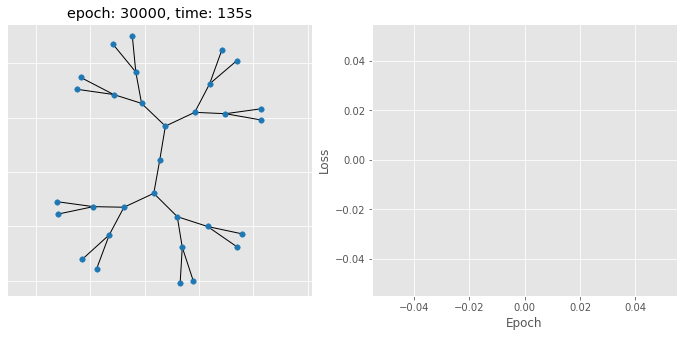

In [675]:

for frac in range(0,101,10):
    #init 
    saveDir = f'fig/stress{int(frac):03d}-angle{int((100-frac)):03d}'
    frac = frac / 100.0
    
    X = X0.clone()
    X.requires_grad_()
    optimizer = optim.SGD([X], lr=0.1, momentum=0.1)
    stressHistory = []
    totalTime = 0
    niter = 30001

    iterBar = tqdm(range(niter))
    for i in iterBar:
        t0 = time.time()
        lr = getLR(i, base_lr=0.1)
        optimizer.param_groups[0]['lr'] = lr
        if X.grad is not None:
            X.grad.fill_(0.0)
        else:
            X.grad = torch.zeros_like(X.data)

        ##vis
        if i % 500 == 0:
    #         iterBar.set_postfix({'stress': s, })
            plot(X, G, [], [], i, totalTime, show=True, 
                 save=True, saveDir=saveDir,
                 grad=False)

        
        ## stress
        n1 = i%len(nodes)
        n2 = (i//len(nodes))%len(nodes)
#         n1, n2 = random.choices(nodes, k=2)
        grad_n1, grad_n2 = stress_grad(X, D, W, n1, n2, base_lr=10)
        X.grad[n1,:] += frac * grad_n1
        X.grad[n2,:] += frac * grad_n2

        
        ## angle
        e1, e2 = random.choices(edges, k=2)
        c=0
        while not has_crossing(X[e1,:], X[e2,:], includeEndpoints=True)\
            and c<10:
            e1, e2 = random.choices(edges, k=2)
            c+=1
        if c<10:
            al = (1-frac) * angle_loss(X, e1, e2)
            al.backward()
        
        ## step
        optimizer.step()

        
        ##debug info
        dt = time.time() - t0
        totalTime += dt

In [634]:
# for dirName in natsorted(glob('fig-stress*')):
#     fn = dirName + '/epoch30000.png'
#     !cp {fn} ./{dirName}.png

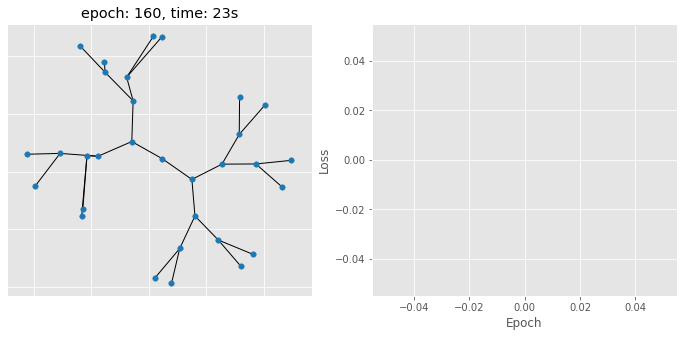

In [527]:
plot(X, G, [], [], i, totalTime, show=True, save=True, grad=False)

## animation

In [241]:
# Create a gif from images in fig/

frames = []
imgs = natsorted(glob('fig/*.png'))

for img in imgs:
    new_frame = Image.open(img)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)